In [ ]:
# @title
!pip install feature-engine
!pip install holidays keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
# @title
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, AveragePooling1D , Flatten, Input, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
import pprint as pp
import keras_tuner as kt
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
df = pd.read_excel("/content/dataset.xlsx")
df

FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset.xlsx'

In [ ]:
df.drop(columns=df.columns[0], axis=1, inplace=True)

In [ ]:
date_time = pd.DataFrame(df['date'])

In [ ]:
df['date'] = df['date'].astype(str) + ' 00:00:00'

In [ ]:
df.head()

In [ ]:
df.describe().transpose()

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [ ]:
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures

def dateTimeToSignal(df):
    '''
    Converts the DateTime index to timestamp and converts it to signal (sine and cosine) to deal with periodicity.
    Input:
        df: DataFrame with a DateTime index
    Output:
        df: DataFrame with additional columns representing Sin/Cosine signals for timestamp, month, day, week, and year
    '''
    # Ensure the index is a datetime object
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    timestamp_s = df.index.map(datetime.datetime.timestamp)
    day = 24 * 60 * 60
    week = 7 * day
    year = 365.2425 * day

    # Extract month and day components
    df['Month'] = df.index.month
    df['Day_of_month'] = df.index.day

    # Apply cyclical features transformer to month and day columns
    cyclical_transformer = CyclicalFeatures(
        variables=['Month', 'Day_of_month'],  # specify the variable to transform
        drop_original=True  # drop the original variables
    )

    df = cyclical_transformer.fit_transform(df)

    df['Week sin'] = np.sin(2 * np.pi * timestamp_s / week)
    df['Week cos'] = np.cos(2 * np.pi * timestamp_s / week)

    df['Year sin'] = np.sin(2 * np.pi * timestamp_s / year)
    df['Year cos'] = np.cos(2 * np.pi * timestamp_s / year)

    return df



In [ ]:
df = dateTimeToSignal(df)

In [ ]:
df

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15))

# Select a subset of the data based on the number of rows to display
subset_df = df.iloc[:365,]

# Plot the sales over time
axes[0].plot(subset_df.index, subset_df['sales'], label='Sales')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales')
axes[0].set_title('Sales Over Time')
axes[0].legend()
axes[0].grid(True)

# Plot the sine and cosine features for day of the month
axes[1].plot(subset_df.index, subset_df['Day_of_month_sin'], label='Day_of_month_sin')
axes[1].plot(subset_df.index, subset_df['Day_of_month_cos'], label='Day_of_month_cos')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].set_title('Day of the Month Features')
axes[1].legend()
axes[1].grid(True)

# Plot the sine and cosine features for month
axes[2].plot(subset_df.index, subset_df['Month_sin'], label='Month_sin')
axes[2].plot(subset_df.index, subset_df['Month_cos'], label='Month_cos')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Value')
axes[2].set_title('Month Features')
axes[2].legend()
axes[2].grid(True)

# Plot the sine and cosine features for week
axes[3].plot(subset_df.index, subset_df['Week sin'], label='Week sin')
axes[3].plot(subset_df.index, subset_df['Week cos'], label='Week cos')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Value')
axes[3].set_title('Week Features')
axes[3].legend()
axes[3].grid(True)

# Plot the sine and cosine features for year
axes[4].plot(subset_df.index, subset_df['Year sin'], label='Year sin')
axes[4].plot(subset_df.index, subset_df['Year cos'], label='Year cos')
axes[4].set_xlabel('Date')
axes[4].set_ylabel('Value')
axes[4].set_title('Year Features')
axes[4].legend()
axes[4].grid(True)

# Adjust subplot spacing
plt.tight_layout()

# Display the plots
plt.show()


In [ ]:
import holidays
from datetime import date

bd_holidays = holidays.BD()

def is_holiday(date):
    # Ensure the date is in the correct format (date object)
    if isinstance(date, str):
        date = date.fromisoformat(date)
    return int(date in bd_holidays)

In [ ]:
df['is_holiday'] = df.index.map(is_holiday)
df['is_holiday']

Most important frequencies:
Frequency: 0.002738225629791895, Period: 365.2 days
Frequency: 0.1429353778751369, Period: 6.996168582375479 days
Frequency: 0.000547645125958379, Period: 1826.0 days
Frequency: 0.2858707557502738, Period: 3.4980842911877397 days


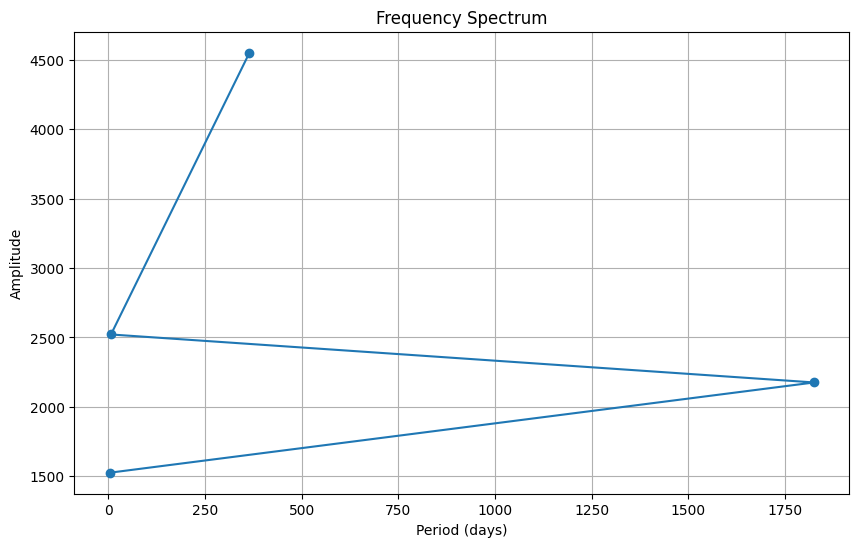

In [ ]:
# Compute the FFT
sales_fft = np.fft.fft(df['sales'])

# Get the frequencies
n = len(df)
frequencies = np.fft.fftfreq(n)
positive_frequencies = frequencies[:n // 2]
amplitudes = np.abs(sales_fft[:n // 2])

# Find the most important frequencies
top_k = 5  # Number of top frequencies to display
top_indices = np.argsort(amplitudes)[::-1][:top_k]

# Plot the frequency spectrum, skipping the first frequency component
plt.figure(figsize=(10, 6))
plt.title("Frequency Spectrum")
plt.plot(1 / positive_frequencies[top_indices[1:]], amplitudes[top_indices[1:]], 'o-')
plt.xlabel("Period (days)")
plt.ylabel("Amplitude")
plt.grid(True)

# Show the most important frequencies, skipping the first one
print("Most important frequencies:")
for idx in top_indices[1:]:
    period = 1 / positive_frequencies[idx]
    print(f"Frequency: {positive_frequencies[idx]}, Period: {period} days")

# Display the plot
plt.show()

Here's an explanation of the output:

Frequency: 0.002738225629791895, Period: 365.2 days:

This frequency component corresponds to a period of approximately one year (365.2 days). It indicates a yearly seasonality in the sales data, suggesting that there is a repeating pattern or seasonality in the sales data with a one-year cycle, which is common in many businesses due to seasonal variations.
Frequency: 0.1429353778751369, Period: 6.996168582375479 days:

This frequency component corresponds to a period of approximately 7 days (6.996 days). It indicates a weekly seasonality in the sales data, suggesting that there is a repeating pattern or seasonality in the sales data with a one-week cycle. This may be related to weekly trends or behaviors in your data.
Frequency: 0.000547645125958379, Period: 1826.0 days:

This frequency component corresponds to a period of approximately 1826 days (about 5 years). It suggests a longer-term cycle or trend in the sales data that repeats every 5 years. This could be associated with macroeconomic or industry-specific factors.
Frequency: 0.2858707557502738, Period: 3.4980842911877397 days:

This frequency component corresponds to a period of approximately 3.5 days. It indicates a short-term cycle or seasonality in the sales data, possibly related to daily fluctuations or events affecting sales on a daily basis.


In summary, the FFT analysis reveals the underlying periodic components in your sales data, helping you understand the different time scales at which patterns and seasonality occur. These insights can be valuable for forecasting, trend analysis, and understanding the dynamics of your sales data.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = 1 # number of target feature

In [ ]:
FEATURES = ['Month_sin', 'Month_cos', 'Day_of_month_sin','Day_of_month_cos', 'Week sin', 'Week cos', 'Year sin', 'Year cos','is_holiday']

In [ ]:
column_indices

{'sales': 0,
 'Month_sin': 1,
 'Month_cos': 2,
 'Day_of_month_sin': 3,
 'Day_of_month_cos': 4,
 'Week sin': 5,
 'Week cos': 6,
 'Year sin': 7,
 'Year cos': 8,
 'is_holiday': 9}

In [ ]:
train_sales = train_df[['sales']]
test_sales = test_df[['sales']]
val_sales = val_df[['sales']]
val_df = val_df.drop(['sales'], axis=1)
train_df = train_df.drop(['sales'], axis=1)
test_df = test_df.drop(['sales'], axis=1)

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_df['sales'] = train_sales[['sales']]
val_df['sales'] = val_sales[['sales']]
test_df['sales'] = test_sales[['sales']]

<ipython-input-22-ed4d3cb812fc>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Column', y='Normalized', data=df_std, palette=palette)
<ipython-input-22-ed4d3cb812fc>:8: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  ax = sns.violinplot(x='Column', y='Normalized', data=df_std, palette=palette)
<ipython-input-22-ed4d3cb812fc>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(df2.keys(), rotation=90)


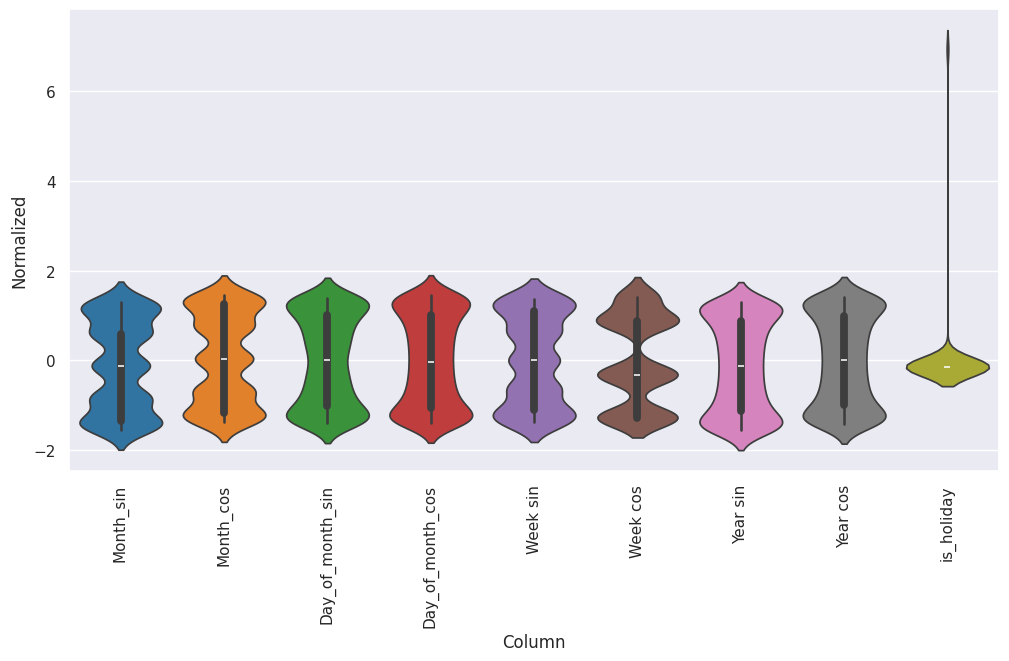

In [ ]:
df2 = df.drop(['sales'], axis=1)
df_std = (df2 - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
# Define the color palette
sns.set(style="darkgrid")
palette = sns.color_palette("tab10")
ax = sns.violinplot(x='Column', y='Normalized', data=df_std, palette=palette)
_ = ax.set_xticklabels(df2.keys(), rotation=90)

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
      # Store the raw data.
      self.train_df = train_df
      self.val_df = val_df
      self.test_df = test_df

      # Work out the label column indices.
      self.label_columns = label_columns
      if label_columns is not None:
        self.label_columns_indices = {name: i for i, name in
                                      enumerate(label_columns)}
      self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

      # Work out the window parameters.
      self.input_width = input_width
      self.label_width = label_width
      self.shift = shift

      self.total_window_size = input_width + shift

      self.input_slice = slice(0, input_width)
      self.input_indices = np.arange(self.total_window_size)[self.input_slice]

      self.label_start = self.total_window_size - self.label_width
      self.labels_slice = slice(self.label_start, None)
      self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
      return '\n'.join([
          f'Total window size: {self.total_window_size}',
          f'Input indices: {self.input_indices}',
          f'Label indices: {self.label_indices}',
          f'Label column name(s): {self.label_columns}'])
    def get_y_true(self, dataset):
        labels = dataset[:, self.label_indices, :]  # Extract labels using label indices
        return labels

In [ ]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col='sales', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Period (day)')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

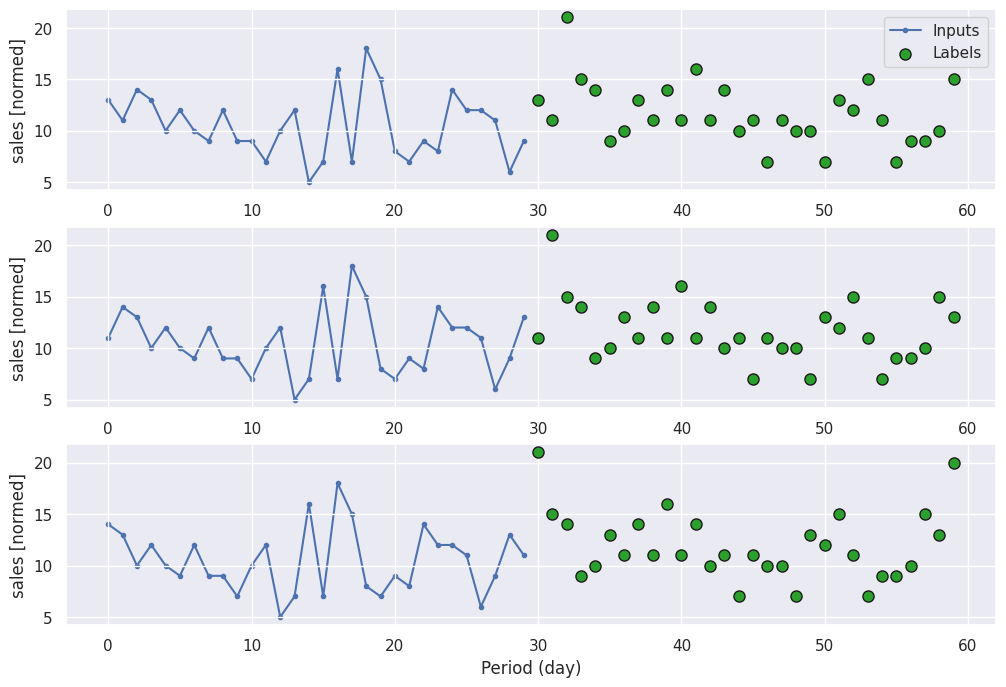

In [ ]:
OUT_STEPS = 30
single_step_window = WindowGenerator(
    input_width=30, label_width=OUT_STEPS, shift=OUT_STEPS, #OUT_STEPS,
    label_columns=['sales'])
single_step_window.plot()

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 10)
Labels shape (batch, time, features): (32, 30, 1)


## BiLSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Flatten, Layer, Conv1D, Input, Concatenate
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential

def bidirectional_LSTM(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(OUT_STEPS, 10)))

    #for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=512, step=64), activation='tanh', recurrent_activation='sigmoid', return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

    return model

tuner = kt.tuners.Hyperband(
    bidirectional_LSTM,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='birectional_lstm_exp',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

Trial 8 Complete [00h 00m 08s]
val_mean_squared_error: 28.553714752197266

Best val_mean_squared_error So Far: 27.687318801879883
Total elapsed time: 00h 01m 18s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 30, 384)           311808    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 384)           0         
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 30)                345630    
                                                                 
 reshape (Reshape)           (None, 30, 1)             0         
                          

In [ ]:
tuner.results_summary()

Results summary
Results in birectional_lstm_exp/demand forecasting
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 0001 summary
Hyperparameters:
units: 192
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 27.687318801879883

Trial 0004 summary
Hyperparameters:
units: 256
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 28.08668327331543

Trial 0005 summary
Hyperparameters:
units: 512
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 28.520732879638672

Trial 0007 summary
Hyperparameters:
units: 128
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 28.553714752197266

Trial 0003 summary
Hyperparameters:
units: 384
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 28.55550765991211

Trial 0002 summary
Hyperparameters:
units: 448
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 28.

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist1 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50
39/39 - 5s - loss: 32.6331 - mean_absolute_error: 4.5471 - root_mean_squared_error: 5.7125 - mean_absolute_percentage_error: 28.1232 - mean_squared_error: 32.6331 - val_loss: 27.1151 - val_mean_absolute_error: 4.1820 - val_root_mean_squared_error: 5.2072 - val_mean_absolute_percentage_error: 23.8898 - val_mean_squared_error: 27.1151 - 5s/epoch - 119ms/step
Epoch 2/50
39/39 - 0s - loss: 29.0042 - mean_absolute_error: 4.2914 - root_mean_squared_error: 5.3856 - mean_absolute_percentage_error: 26.6290 - mean_squared_error: 29.0042 - val_loss: 25.2529 - val_mean_absolute_error: 4.0384 - val_root_mean_squared_error: 5.0252 - val_mean_absolute_percentage_error: 22.5000 - val_mean_squared_error: 25.2529 - 410ms/epoch - 11ms/step
Epoch 3/50
39/39 - 0s - loss: 27.7029 - mean_absolute_error: 4.1861 - root_mean_squared_error: 5.2634 - mean_absolute_percentage_error: 25.8660 - mean_squared_error: 27.7029 - val_loss: 25.1161 - val_mean_absolute_error: 4.0401 - val_root_mean_squared_error:

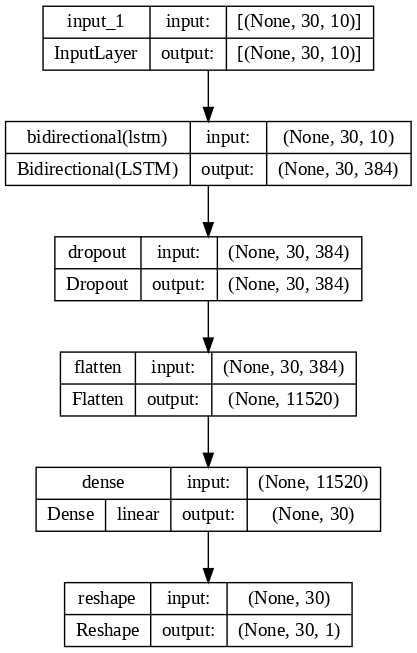

In [ ]:
plot_model(best_model, show_shapes=True, show_layer_names = True, show_layer_activations=True, dpi=100)

In [ ]:
best_model.evaluate(single_step_window.val, return_dict=True)

10/10 [==============================] - 0s 10ms/step - loss: 22.9798 - mean_absolute_error: 3.8917 - root_mean_squared_error: 4.7937 - mean_absolute_percentage_error: 20.8595 - mean_squared_error: 22.9798


{'loss': 22.97983169555664,
 'mean_absolute_error': 3.8917007446289062,
 'root_mean_squared_error': 4.793728828430176,
 'mean_absolute_percentage_error': 20.8594913482666,
 'mean_squared_error': 22.979833602905273}

In [ ]:
score

{'loss': 23.721532821655273,
 'mean_absolute_error': 4.023697853088379,
 'root_mean_squared_error': 4.8704752922058105,
 'mean_absolute_percentage_error': 20.152429580688477,
 'mean_squared_error': 23.72153091430664}

In [ ]:
pd.DataFrame(hist1.history).head()

,loss,mean_absolute_error,root_mean_squared_error,mean_absolute_percentage_error,mean_squared_error,val_loss,val_mean_absolute_error,val_root_mean_squared_error,val_mean_absolute_percentage_error,val_mean_squared_error
0,32.633102,4.547120,5.712539,28.123226,32.633106,27.115139,4.181994,5.207220,23.889765,27.115139
1,29.004232,4.291353,5.385557,26.628952,29.004229,25.252909,4.038446,5.025227,22.500017,25.252907
2,27.702919,4.186129,5.263357,25.865957,27.702925,25.116144,4.040089,5.011601,22.407665,25.116144
3,27.259703,4.150819,5.221082,25.584356,27.259699,25.029804,4.033122,5.002980,22.349201,25.029806
4,26.991024,4.126690,5.195288,25.422829,26.991020,24.940470,4.023691,4.994043,22.226147,24.940468


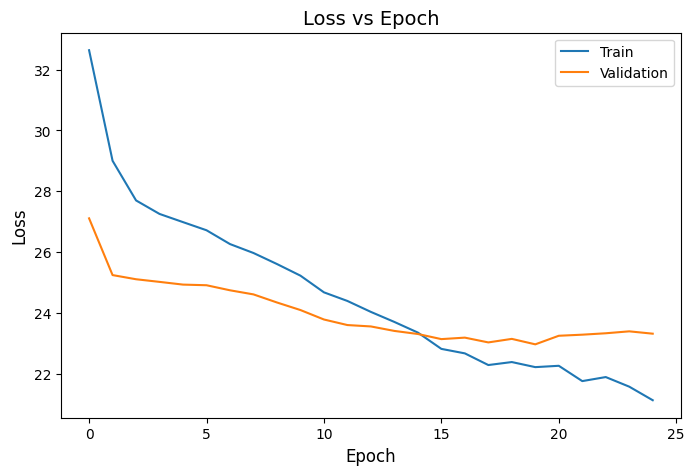

In [ ]:
# "Loss"
plt.figure(figsize=[8,5])
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('Loss vs Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("bilstm_loss.png", dpi=300)
plt.show()

In [ ]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

# Initialize lists to store t-statistics and p-values
t_statistics = []
p_values = []

from scipy import stats
t_statistic, p_value = stats.ttest_ind(y_pred, y_test)

# Append the results to the lists
t_statistics.append(t_statistic)
p_values.append(p_value)

# Aggregate the results (e.g., by taking the mean)
mean_t_statistic = np.mean(t_statistics)
mean_p_value = np.mean(p_values)

print("Mean t-statistic:", mean_t_statistic)
print("Mean p-value:", mean_p_value)

Mean t-statistic: -1.4927164
Mean p-value: 0.19891497


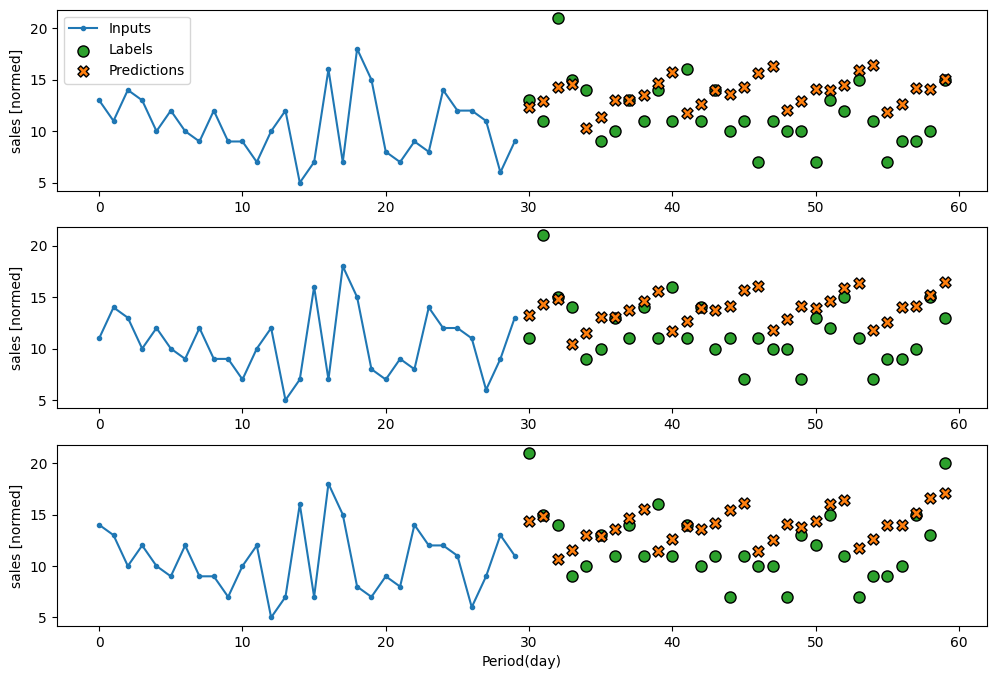

In [ ]:
single_step_window.plot(best_model)

## CNN

In [ ]:
def cnn_model(hp):
  model = tf.keras.Sequential()
  model.add(Input(shape=(OUT_STEPS, 10)))

  num_filters = hp.Int('filters_cnn_layer', min_value=16, max_value=512, step=16)
  k_size = hp.Int('kernel_size', min_value=1, max_value=3, step=1)

  model.add(Conv1D(num_filters, k_size, activation='relu'))
  if hp.Choice('pooling_', ['avg', 'max']) == 'max':
    model.add(MaxPooling1D())
  else:
    model.add(AveragePooling1D())

  model.add(Flatten())
  model.add(Dense(hp.Int('units_fully_connected_dense', min_value=16, max_value=512, step=16), activation='relu'))
  model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros(), activation='linear'))
  model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))
  model.compile(optimizer="adam", loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])

  return model

tuner = kt.tuners.Hyperband(
    cnn_model,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='cnn_exp',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

Trial 150 Complete [00h 00m 09s]
val_mean_squared_error: 26.817073822021484

Best val_mean_squared_error So Far: 26.225170135498047
Total elapsed time: 00h 11m 51s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            704       
                                                                 
 average_pooling1d (Average  (None, 15, 64)            0         
 Pooling1D)                                                      
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 192)               184512    
                                                                 
 dense_1 (Dense)             (None, 30)                5790      
                        

In [ ]:
tuner.results_summary()

Results summary
Results in cnn_exp/demand forecasting
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 0085 summary
Hyperparameters:
filters_cnn_layer: 64
kernel_size: 1
pooling_: avg
units_fully_connected_dense: 192
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0079
Score: 26.225170135498047

Trial 0144 summary
Hyperparameters:
filters_cnn_layer: 176
kernel_size: 1
pooling_: avg
units_fully_connected_dense: 448
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0141
Score: 26.303508758544922

Trial 0059 summary
Hyperparameters:
filters_cnn_layer: 32
kernel_size: 2
pooling_: avg
units_fully_connected_dense: 160
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 26.349002838134766

Trial 0146 summary
Hyperparameters:
filters_cnn_layer: 16
kernel_size: 1
pooling_: max
units_fully_connected_dense: 208
tuner/epochs: 10
tuner/initial_epoch: 0
tune

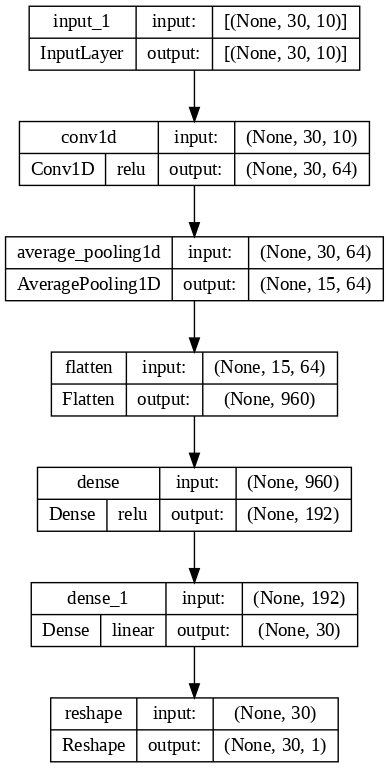

In [ ]:
plot_model(best_model, show_shapes=True, show_layer_names = True, show_layer_activations=True, dpi=100)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist2 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50
39/39 - 2s - loss: 25.4127 - mean_absolute_error: 3.9911 - root_mean_squared_error: 5.0411 - mean_squared_error: 25.4127 - mean_absolute_percentage_error: 24.5957 - val_loss: 26.0846 - val_mean_absolute_error: 4.1164 - val_root_mean_squared_error: 5.1073 - val_mean_squared_error: 26.0846 - val_mean_absolute_percentage_error: 22.7124 - 2s/epoch - 39ms/step
Epoch 2/50
39/39 - 0s - loss: 25.1752 - mean_absolute_error: 3.9708 - root_mean_squared_error: 5.0175 - mean_squared_error: 25.1752 - mean_absolute_percentage_error: 24.3852 - val_loss: 26.0268 - val_mean_absolute_error: 4.1250 - val_root_mean_squared_error: 5.1016 - val_mean_squared_error: 26.0268 - val_mean_absolute_percentage_error: 23.1245 - 279ms/epoch - 7ms/step
Epoch 3/50
39/39 - 0s - loss: 25.1202 - mean_absolute_error: 3.9721 - root_mean_squared_error: 5.0120 - mean_squared_error: 25.1202 - mean_absolute_percentage_error: 24.5023 - val_loss: 26.0600 - val_mean_absolute_error: 4.1115 - val_root_mean_squared_error: 5

In [ ]:
best_model.evaluate(single_step_window.val, return_dict=True)

10/10 [==============================] - 0s 5ms/step - loss: 26.0268 - mean_absolute_error: 4.1250 - root_mean_squared_error: 5.1016 - mean_squared_error: 26.0268 - mean_absolute_percentage_error: 23.1245


{'loss': 26.02678108215332,
 'mean_absolute_error': 4.125034332275391,
 'root_mean_squared_error': 5.101644515991211,
 'mean_squared_error': 26.026779174804688,
 'mean_absolute_percentage_error': 23.124460220336914}

In [ ]:
score

{'loss': 28.709957122802734,
 'mean_absolute_error': 4.215632915496826,
 'root_mean_squared_error': 5.3581671714782715,
 'mean_squared_error': 28.709957122802734,
 'mean_absolute_percentage_error': 23.06070899963379}

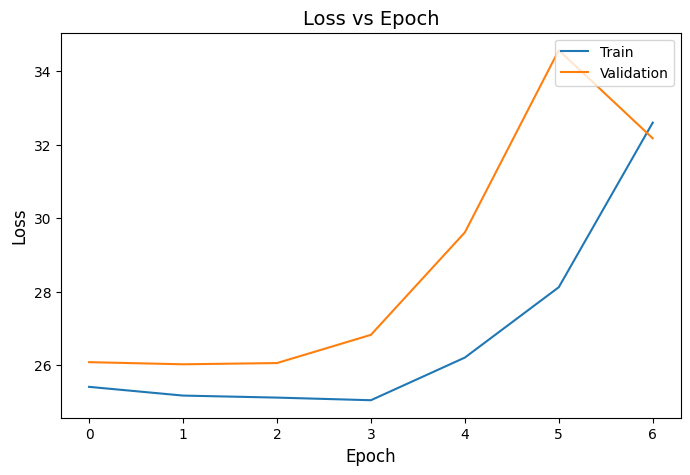

In [ ]:
# "Loss"
plt.figure(figsize=[8,5])
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Loss vs Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("cnn_loss.png", dpi=300)
plt.show()

In [ ]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

# Initialize lists to store t-statistics and p-values
t_statistics = []
p_values = []

from scipy import stats
t_statistic, p_value = stats.ttest_ind(y_pred, y_test)

# Append the results to the lists
t_statistics.append(t_statistic)
p_values.append(p_value)

# Aggregate the results (e.g., by taking the mean)
mean_t_statistic = np.mean(t_statistics)
mean_p_value = np.mean(p_values)

print("Mean t-statistic:", mean_t_statistic)
print("Mean p-value:", mean_p_value)

Mean t-statistic: 0.22919855
Mean p-value: 0.5663907


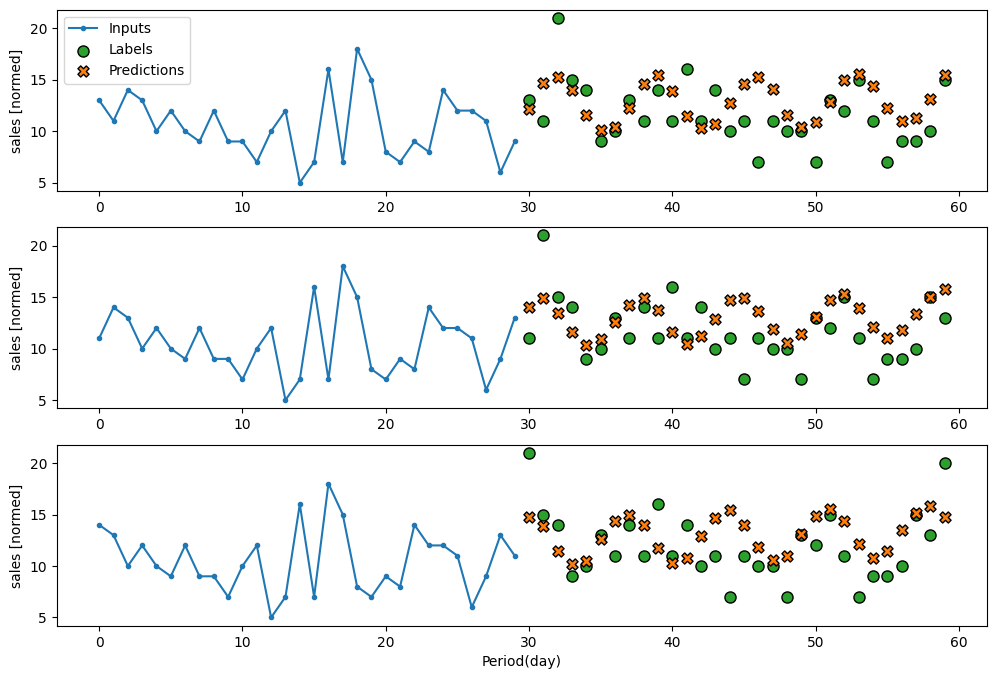

In [ ]:
single_step_window.plot(best_model)

## RNN

In [ ]:
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, AveragePooling1D , Flatten, Input, LSTM, Bidirectional, SimpleRNN

def RNN_model(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(OUT_STEPS, 10)))
    #for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
    #model.add(SimpleRNN(units=hp.Int('units' + str(i), min_value=32, max_value=512, step=32), activation="tanh", use_bias=True, return_sequences=True))
    model.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=512, step=32), activation="tanh", use_bias=True, return_sequences=True))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0)))
    model.add(Flatten())
    model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))

    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

    return model

tuner = kt.tuners.Hyperband(
    RNN_model,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='rnn_exp',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

Trial 95 Complete [00h 00m 06s]
val_mean_squared_error: 28.095840454101562

Best val_mean_squared_error So Far: 23.36810874938965
Total elapsed time: 00h 13m 59s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30, 128)           17792     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 30)                115230    
                                                                 
 reshape (Reshape)           (None, 30, 1)             0         
                                                                 
Total params: 133022 (519.

In [ ]:
tuner.results_summary()

Results summary
Results in rnn_exp/demand forecasting
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 0084 summary
Hyperparameters:
units: 128
dropout: 0.1
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0079
Score: 23.36810874938965

Trial 0017 summary
Hyperparameters:
units: 128
dropout: 0.30000000000000004
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 23.39458656311035

Trial 0016 summary
Hyperparameters:
units: 160
dropout: 0.30000000000000004
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0014
Score: 23.420040130615234

Trial 0029 summary
Hyperparameters:
units: 224
dropout: 0.2
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 23.468740463256836

Trial 0085 summary
Hyperparameters:
units: 192
dropout: 0.30000000000000004
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tu

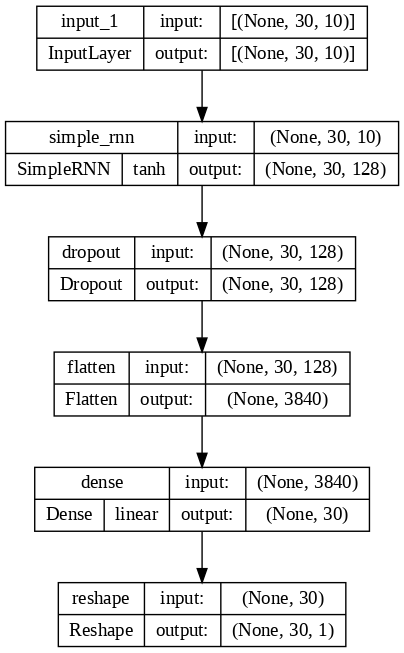

In [ ]:
plot_model(best_model, show_shapes=True, show_layer_names = True,  show_layer_activations=True, dpi=100)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist3 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50
39/39 - 2s - loss: 23.0389 - mean_absolute_error: 3.8125 - root_mean_squared_error: 4.7999 - mean_absolute_percentage_error: 23.3866 - mean_squared_error: 23.0389 - val_loss: 23.4650 - val_mean_absolute_error: 3.9306 - val_root_mean_squared_error: 4.8441 - val_mean_absolute_percentage_error: 21.7769 - val_mean_squared_error: 23.4650 - 2s/epoch - 63ms/step
Epoch 2/50
39/39 - 1s - loss: 22.8797 - mean_absolute_error: 3.8092 - root_mean_squared_error: 4.7833 - mean_absolute_percentage_error: 23.3839 - mean_squared_error: 22.8797 - val_loss: 23.2917 - val_mean_absolute_error: 3.9150 - val_root_mean_squared_error: 4.8261 - val_mean_absolute_percentage_error: 21.6581 - val_mean_squared_error: 23.2917 - 937ms/epoch - 24ms/step
Epoch 3/50
39/39 - 1s - loss: 22.5589 - mean_absolute_error: 3.7773 - root_mean_squared_error: 4.7496 - mean_absolute_percentage_error: 23.1718 - mean_squared_error: 22.5589 - val_loss: 23.3839 - val_mean_absolute_error: 3.9222 - val_root_mean_squared_error: 

In [ ]:
best_model.evaluate(single_step_window.val, return_dict=True)

10/10 [==============================] - 0s 8ms/step - loss: 23.2788 - mean_absolute_error: 3.9130 - root_mean_squared_error: 4.8248 - mean_absolute_percentage_error: 21.4356 - mean_squared_error: 23.2788


{'loss': 23.278825759887695,
 'mean_absolute_error': 3.9130170345306396,
 'root_mean_squared_error': 4.8248138427734375,
 'mean_absolute_percentage_error': 21.43556022644043,
 'mean_squared_error': 23.278827667236328}

In [ ]:
score

{'loss': 23.933170318603516,
 'mean_absolute_error': 4.05010986328125,
 'root_mean_squared_error': 4.892153739929199,
 'mean_absolute_percentage_error': 20.884471893310547,
 'mean_squared_error': 23.933170318603516}

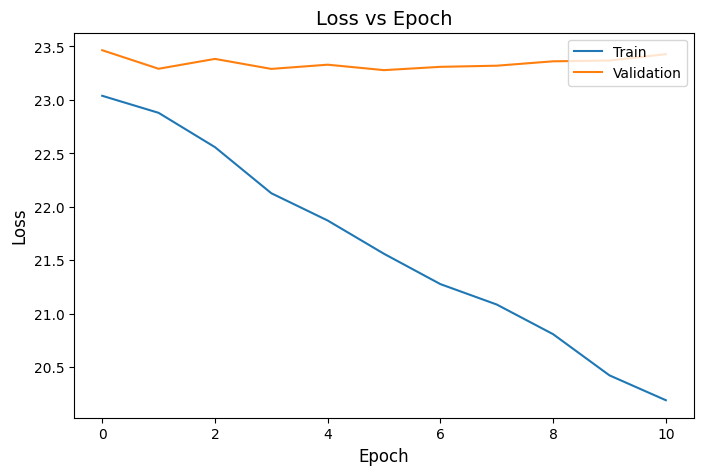

In [ ]:
# "Loss"
plt.figure(figsize=[8,5])
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('Loss vs Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("rnn_loss.png", dpi=300)
plt.show()

In [ ]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

# Initialize lists to store t-statistics and p-values
t_statistics = []
p_values = []

from scipy import stats
t_statistic, p_value = stats.ttest_ind(y_pred, y_test)

# Append the results to the lists
t_statistics.append(t_statistic)
p_values.append(p_value)

# Aggregate the results (e.g., by taking the mean)
mean_t_statistic = np.mean(t_statistics)
mean_p_value = np.mean(p_values)

print("Mean t-statistic:", mean_t_statistic)
print("Mean p-value:", mean_p_value)

Mean t-statistic: -0.68015826
Mean p-value: 0.48447892


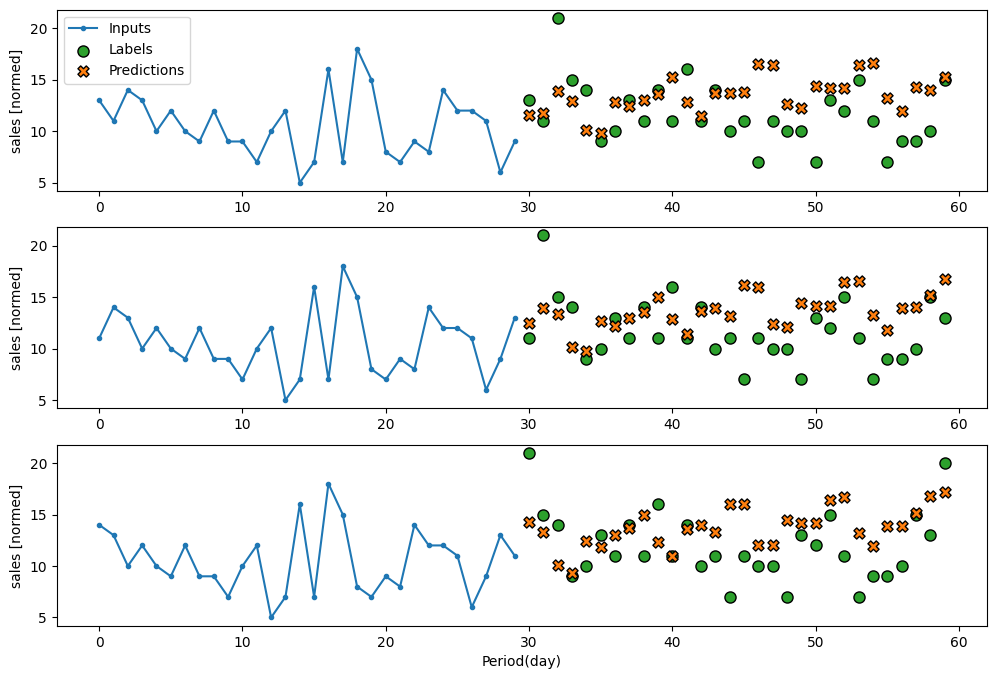

In [ ]:
single_step_window.plot(best_model)

## Stacked LSTM

In [ ]:
def stacked_LSTM(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(OUT_STEPS, 10)))

    #for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0)))
    model.add(Flatten())
    model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))


    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

    return model

tuner = kt.tuners.Hyperband(
    stacked_LSTM,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='stacked_lstm_exp',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

Trial 96 Complete [00h 00m 09s]
val_mean_squared_error: 38.3703498840332

Best val_mean_squared_error So Far: 28.168014526367188
Total elapsed time: 00h 16m 06s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 512)           1071104   
                                                                 
 dropout (Dropout)           (None, 30, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 512)           2099200   
                                                                 
 dropout_1 (Dropout)         (None, 30, 512)           0         
                                                                 
 flatten (Flatten)           (None, 15360)             0         
                                                                 
 dense (Dense)             

In [ ]:
tuner.results_summary()

Results summary
Results in stacked_lstm_exp/demand forecasting
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 0058 summary
Hyperparameters:
units: 512
dropout: 0.0
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 28.168014526367188

Trial 0056 summary
Hyperparameters:
units: 480
dropout: 0.0
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 28.25672721862793

Trial 0059 summary
Hyperparameters:
units: 288
dropout: 0.0
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 28.2739315032959

Trial 0076 summary
Hyperparameters:
units: 128
dropout: 0.30000000000000004
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0074
Score: 28.46781349182129

Trial 0057 summary
Hyperparameters:
units: 288
dropout: 0.2
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 28.49770736694336

Trial 0087 summary
Hyperpara

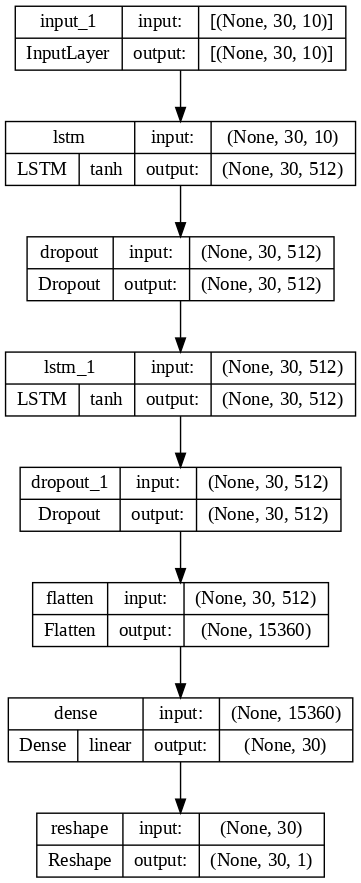

In [ ]:
plot_model(best_model, show_shapes=True, show_layer_names = True,  show_layer_activations=True, dpi=100)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist4 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50
39/39 - 5s - loss: 32.1473 - mean_absolute_error: 4.5191 - root_mean_squared_error: 5.6699 - mean_absolute_percentage_error: 28.0650 - mean_squared_error: 32.1473 - val_loss: 27.5729 - val_mean_absolute_error: 4.1746 - val_root_mean_squared_error: 5.2510 - val_mean_absolute_percentage_error: 23.0542 - val_mean_squared_error: 27.5729 - 5s/epoch - 127ms/step
Epoch 2/50
39/39 - 1s - loss: 31.9838 - mean_absolute_error: 4.5072 - root_mean_squared_error: 5.6554 - mean_absolute_percentage_error: 27.8330 - mean_squared_error: 31.9838 - val_loss: 27.0987 - val_mean_absolute_error: 4.1256 - val_root_mean_squared_error: 5.2056 - val_mean_absolute_percentage_error: 22.5055 - val_mean_squared_error: 27.0987 - 596ms/epoch - 15ms/step
Epoch 3/50
39/39 - 1s - loss: 29.5371 - mean_absolute_error: 4.3333 - root_mean_squared_error: 5.4348 - mean_absolute_percentage_error: 27.0351 - mean_squared_error: 29.5371 - val_loss: 25.1050 - val_mean_absolute_error: 4.0093 - val_root_mean_squared_error:

In [ ]:
best_model.evaluate(single_step_window.val, return_dict=True)

10/10 [==============================] - 0s 8ms/step - loss: 23.1541 - mean_absolute_error: 3.8722 - root_mean_squared_error: 4.8119 - mean_absolute_percentage_error: 20.8744 - mean_squared_error: 23.1541


{'loss': 23.154083251953125,
 'mean_absolute_error': 3.872175931930542,
 'root_mean_squared_error': 4.811868667602539,
 'mean_absolute_percentage_error': 20.874418258666992,
 'mean_squared_error': 23.154083251953125}

In [ ]:
score

{'loss': 24.228548049926758,
 'mean_absolute_error': 4.034303665161133,
 'root_mean_squared_error': 4.922250270843506,
 'mean_absolute_percentage_error': 20.242826461791992,
 'mean_squared_error': 24.228548049926758}

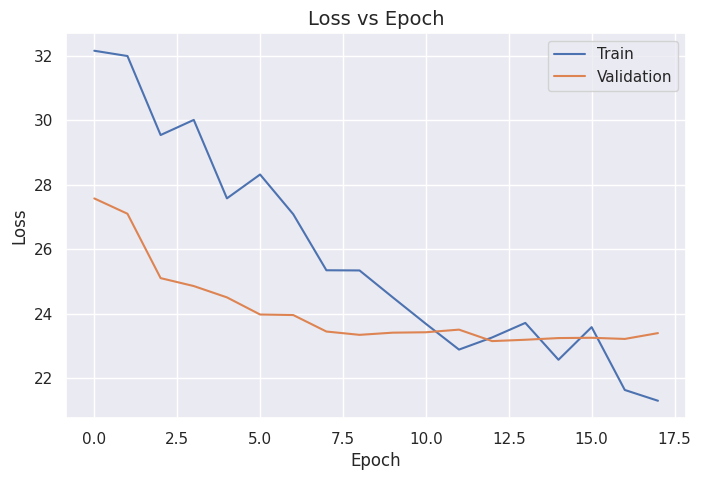

In [ ]:
# "Loss"
plt.figure(figsize=[8,5])
plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])
plt.title('Loss vs Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("stacked_lstm_loss.png", dpi=300)
plt.show()

In [ ]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

# Initialize lists to store t-statistics and p-values
t_statistics = []
p_values = []

from scipy import stats
t_statistic, p_value = stats.ttest_ind(y_pred, y_test)

# Append the results to the lists
t_statistics.append(t_statistic)
p_values.append(p_value)

# Aggregate the results (e.g., by taking the mean)
mean_t_statistic = np.mean(t_statistics)
mean_p_value = np.mean(p_values)

print("Mean t-statistic:", mean_t_statistic)
print("Mean p-value:", mean_p_value)

Mean t-statistic: -1.0124743
Mean p-value: 0.3461518


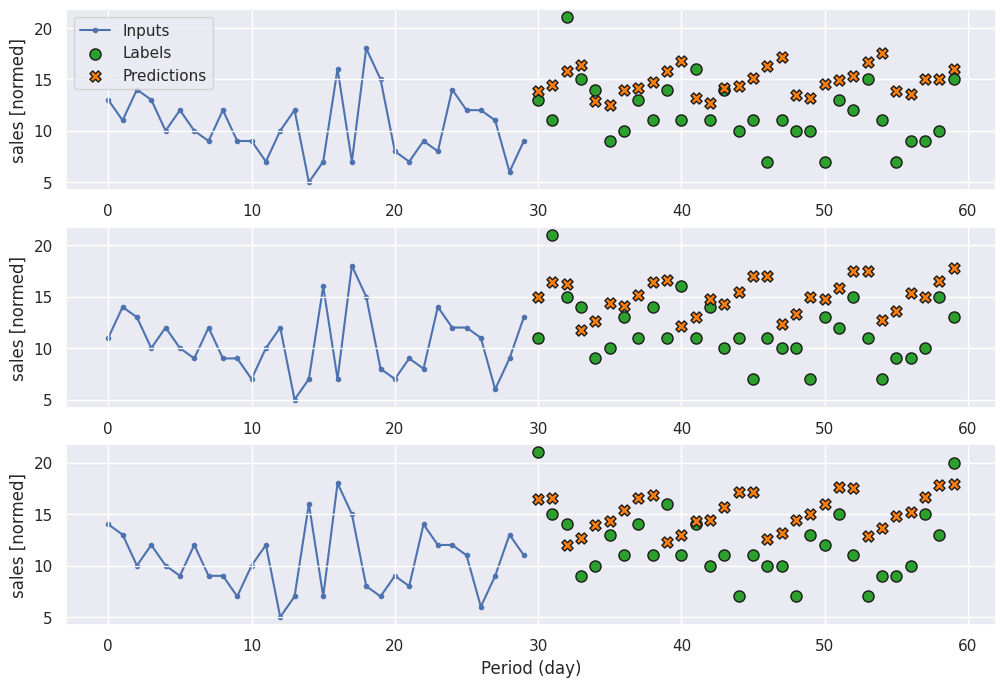

In [ ]:
single_step_window.plot(best_model)

## Vanilla LSTM

In [ ]:
def vanila_LSTM(hp):
    inputs = Input(shape=(OUT_STEPS, 10))
    X = LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='tanh', recurrent_activation='sigmoid')(inputs)
    outputs = Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros())(X)
    outputs = tf.keras.layers.Reshape([OUT_STEPS, num_features])(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="vanilla_lstm_model")

    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

    return model

tuner = kt.tuners.Hyperband(
    vanila_LSTM,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='vanilla',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

Trial 22 Complete [00h 00m 06s]
val_mean_squared_error: 39.98261642456055

Best val_mean_squared_error So Far: 39.92511749267578
Total elapsed time: 00h 02m 09s
Model: "vanilla_lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 10)]          0         
                                                                 
 lstm (LSTM)                 (None, 480)               942720    
                                                                 
 dense (Dense)               (None, 30)                14430     
                                                                 
 reshape (Reshape)           (None, 30, 1)             0         
                                                                 
Total params: 957150 (3.65 MB)
Trainable params: 957150 (3.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________

In [ ]:
tuner.results_summary()

Results summary
Results in vanilla/demand forecasting
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 0006 summary
Hyperparameters:
units: 480
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 39.92511749267578

Trial 0000 summary
Hyperparameters:
units: 448
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 39.981056213378906

Trial 0021 summary
Hyperparameters:
units: 512
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 39.98261642456055

Trial 0004 summary
Hyperparameters:
units: 416
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 40.23431396484375

Trial 0016 summary
Hyperparameters:
units: 480
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 40.30371856689453

Trial 0017 summary
Hyperparameters:
units: 448
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tu

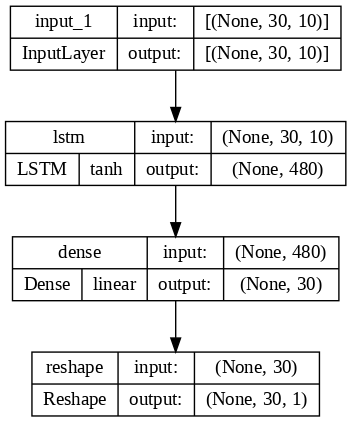

In [ ]:
plot_model(best_model, show_shapes=True, show_layer_names = True,  show_layer_activations=True, dpi=100)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist5 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50
39/39 - 3s - loss: 41.8360 - mean_absolute_error: 5.1463 - root_mean_squared_error: 6.4681 - mean_absolute_percentage_error: 33.1110 - mean_squared_error: 41.8360 - val_loss: 40.8680 - val_mean_absolute_error: 5.0870 - val_root_mean_squared_error: 6.3928 - val_mean_absolute_percentage_error: 27.0097 - val_mean_squared_error: 40.8680 - 3s/epoch - 74ms/step
Epoch 2/50
39/39 - 0s - loss: 41.3438 - mean_absolute_error: 5.1115 - root_mean_squared_error: 6.4299 - mean_absolute_percentage_error: 32.7239 - mean_squared_error: 41.3438 - val_loss: 40.6039 - val_mean_absolute_error: 5.0737 - val_root_mean_squared_error: 6.3721 - val_mean_absolute_percentage_error: 27.0937 - val_mean_squared_error: 40.6039 - 366ms/epoch - 9ms/step
Epoch 3/50
39/39 - 0s - loss: 41.5745 - mean_absolute_error: 5.1268 - root_mean_squared_error: 6.4478 - mean_absolute_percentage_error: 32.8474 - mean_squared_error: 41.5745 - val_loss: 40.5373 - val_mean_absolute_error: 5.0702 - val_root_mean_squared_error: 6

In [ ]:
best_model.evaluate(single_step_window.val, return_dict=True)

10/10 [==============================] - 0s 5ms/step - loss: 40.0588 - mean_absolute_error: 5.0427 - root_mean_squared_error: 6.3292 - mean_absolute_percentage_error: 27.3034 - mean_squared_error: 40.0588


{'loss': 40.05881118774414,
 'mean_absolute_error': 5.042665004730225,
 'root_mean_squared_error': 6.329202651977539,
 'mean_absolute_percentage_error': 27.303373336791992,
 'mean_squared_error': 40.058807373046875}

In [ ]:
score

{'loss': 43.773014068603516,
 'mean_absolute_error': 5.286630153656006,
 'root_mean_squared_error': 6.616117477416992,
 'mean_absolute_percentage_error': 25.570451736450195,
 'mean_squared_error': 43.77301025390625}

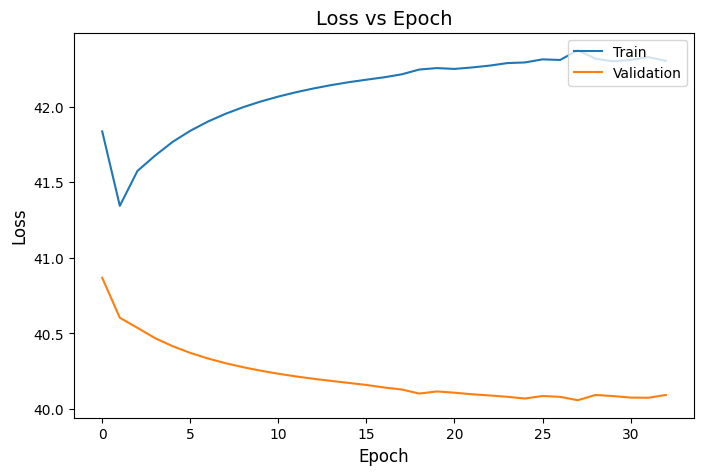

In [ ]:
# "Loss"
plt.figure(figsize=[8,5])
plt.plot(hist5.history['loss'])
plt.plot(hist5.history['val_loss'])
plt.title('Loss vs Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("vanilla_lstm_loss.png", dpi=300)
plt.show()

In [ ]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

# Initialize lists to store t-statistics and p-values
t_statistics = []
p_values = []

from scipy import stats
t_statistic, p_value = stats.ttest_ind(y_pred, y_test)

# Append the results to the lists
t_statistics.append(t_statistic)
p_values.append(p_value)

# Aggregate the results (e.g., by taking the mean)
mean_t_statistic = np.mean(t_statistics)
mean_p_value = np.mean(p_values)

print("Mean t-statistic:", mean_t_statistic)
print("Mean p-value:", mean_p_value)

Mean t-statistic: -4.283157
Mean p-value: 0.004519258


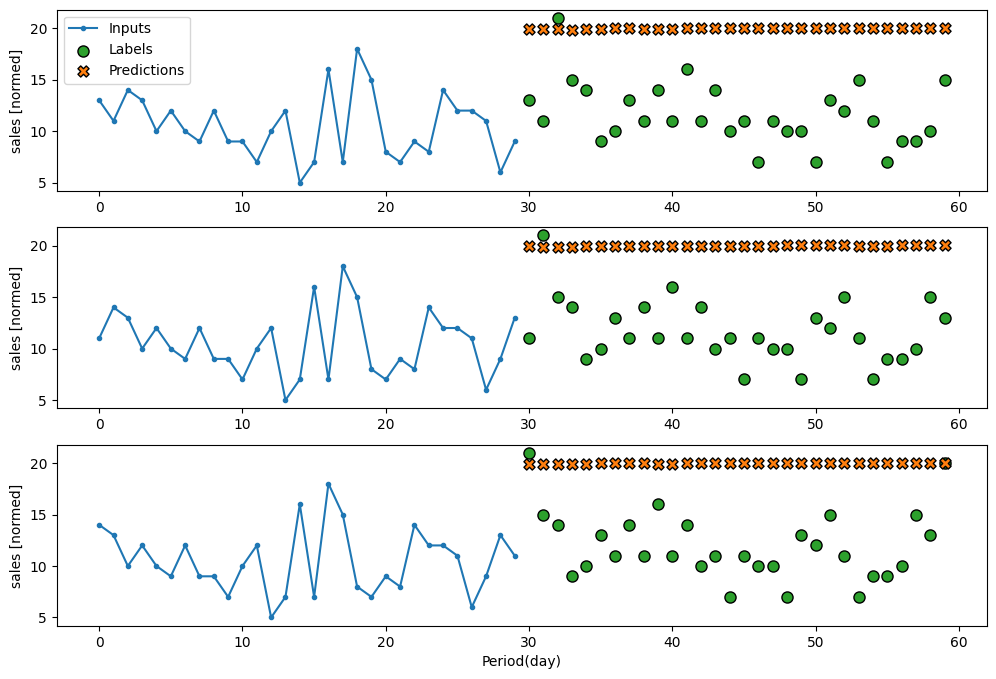

In [ ]:
single_step_window.plot(best_model)

## MLP

In [ ]:
def mlp_model(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(OUT_STEPS, 10)))

    #for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
    #  hp_activation=hp.Choice('activation' + str(i), ['relu', 'tanh', 'relu'])
    hp_activation=hp.Choice('activation', ['relu', 'tanh', 'relu'])
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation=hp_activation))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.0)))

    model.add(Dense(num_features, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])

    return model


tuner = kt.tuners.Hyperband(
    mlp_model,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='mlp',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

Trial 150 Complete [00h 00m 07s]
val_mean_squared_error: 39.10385513305664

Best val_mean_squared_error So Far: 27.790449142456055
Total elapsed time: 00h 10m 20s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30, 512)           5632      
                                                                 
 dropout (Dropout)           (None, 30, 512)           0         
                                                                 
 dense_1 (Dense)             (None, 30, 1)             513       
                                                                 
Total params: 6145 (24.00 KB)
Trainable params: 6145 (24.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tuner.results_summary()

Results summary
Results in mlp/demand forecasting
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 0054 summary
Hyperparameters:
activation: tanh
units: 512
dropout: 0.0
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0049
Score: 27.790449142456055

Trial 0136 summary
Hyperparameters:
activation: tanh
units: 512
dropout: 0.1
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0132
Score: 27.80330467224121

Trial 0016 summary
Hyperparameters:
activation: tanh
units: 480
dropout: 0.30000000000000004
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 27.84955406188965

Trial 0084 summary
Hyperparameters:
activation: tanh
units: 448
dropout: 0.1
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0080
Score: 27.90016746520996

Trial 0024 summary
Hyperparameters:
activation: tanh
units: 416
dro

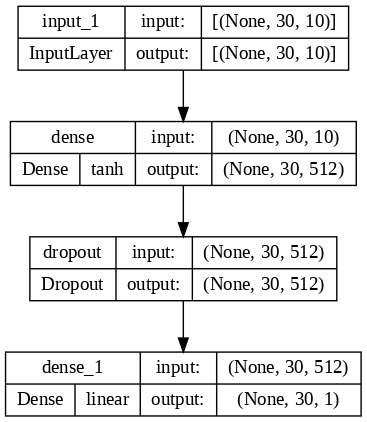

In [ ]:
plot_model(best_model, show_shapes=True, show_layer_names = True,  show_layer_activations=True, dpi=100)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist6 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50
39/39 - 1s - loss: 30.1480 - mean_absolute_error: 4.3275 - mean_squared_error: 30.1480 - root_mean_squared_error: 5.4907 - mean_absolute_percentage_error: 26.6144 - val_loss: 27.5290 - val_mean_absolute_error: 4.1693 - val_mean_squared_error: 27.5290 - val_root_mean_squared_error: 5.2468 - val_mean_absolute_percentage_error: 22.7542 - 1s/epoch - 37ms/step
Epoch 2/50
39/39 - 0s - loss: 30.0961 - mean_absolute_error: 4.3264 - mean_squared_error: 30.0961 - root_mean_squared_error: 5.4860 - mean_absolute_percentage_error: 26.6018 - val_loss: 27.3174 - val_mean_absolute_error: 4.1578 - val_mean_squared_error: 27.3174 - val_root_mean_squared_error: 5.2266 - val_mean_absolute_percentage_error: 22.7106 - 281ms/epoch - 7ms/step
Epoch 3/50
39/39 - 0s - loss: 30.0435 - mean_absolute_error: 4.3248 - mean_squared_error: 30.0435 - root_mean_squared_error: 5.4812 - mean_absolute_percentage_error: 26.5910 - val_loss: 27.1434 - val_mean_absolute_error: 4.1478 - val_mean_squared_error: 27.143

In [ ]:
best_model.evaluate(single_step_window.val, return_dict=True)

10/10 [==============================] - 0s 8ms/step - loss: 24.5930 - mean_absolute_error: 3.9819 - mean_squared_error: 24.5930 - root_mean_squared_error: 4.9591 - mean_absolute_percentage_error: 21.3460


{'loss': 24.59302520751953,
 'mean_absolute_error': 3.981856346130371,
 'mean_squared_error': 24.59302520751953,
 'root_mean_squared_error': 4.95913553237915,
 'mean_absolute_percentage_error': 21.3459529876709}

In [ ]:
score

{'loss': 27.082862854003906,
 'mean_absolute_error': 4.117091655731201,
 'mean_squared_error': 27.082862854003906,
 'root_mean_squared_error': 5.204119682312012,
 'mean_absolute_percentage_error': 20.705341339111328}

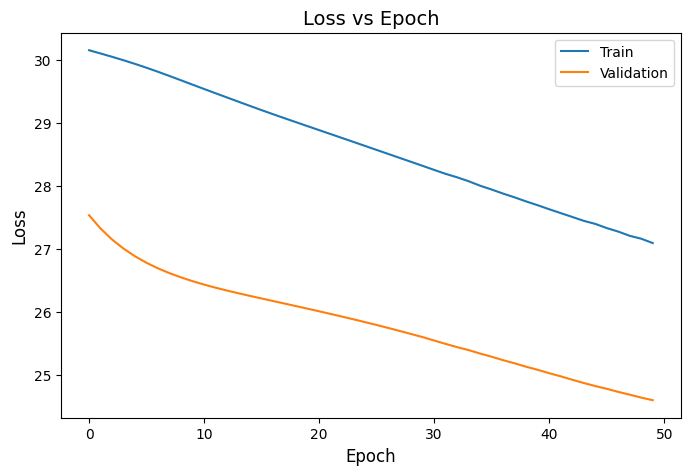

In [ ]:
# "Loss"
plt.figure(figsize=[8,5])
plt.plot(hist6.history['loss'])
plt.plot(hist6.history['val_loss'])
plt.title('Loss vs Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("mlp_loss.png", dpi=300)
plt.show()

In [ ]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

# Initialize lists to store t-statistics and p-values
t_statistics = []
p_values = []

from scipy import stats
t_statistic, p_value = stats.ttest_ind(y_pred, y_test)

# Append the results to the lists
t_statistics.append(t_statistic)
p_values.append(p_value)

# Aggregate the results (e.g., by taking the mean)
mean_t_statistic = np.mean(t_statistics)
mean_p_value = np.mean(p_values)

print("Mean t-statistic:", mean_t_statistic)
print("Mean p-value:", mean_p_value)

Mean t-statistic: -2.0900013
Mean p-value: 0.05574129


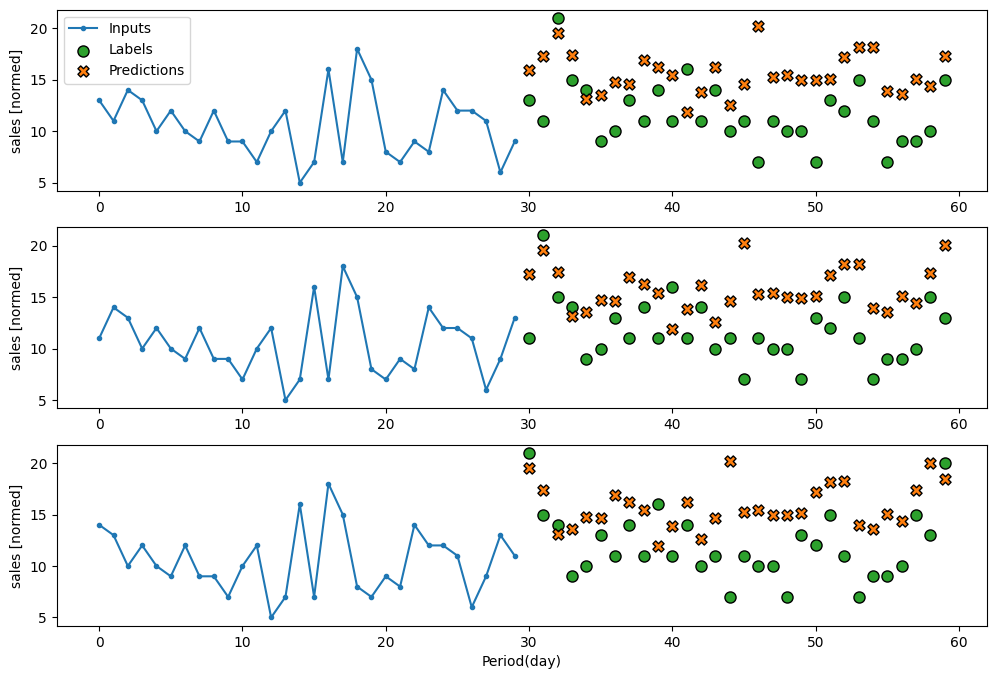

In [ ]:
single_step_window.plot(best_model)

## GRU

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Dropout, LSTM, Bidirectional, Flatten, Layer, Conv1D, Input, Concatenate
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential

def gru(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(OUT_STEPS, 10)))

    #for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
    model.add(GRU(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=True))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0)))
    model.add(Flatten())
    model.add(Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()))
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))

    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

    return model

tuner = kt.tuners.Hyperband(
    gru,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=5,
    directory='gru',
    project_name='demand forecasting')

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(24, 10))
best_model.summary()

Trial 96 Complete [00h 00m 09s]
val_mean_squared_error: 26.759309768676758

Best val_mean_squared_error So Far: 23.837831497192383
Total elapsed time: 00h 13m 32s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 192)           117504    
                                                                 
 dropout (Dropout)           (None, 30, 192)           0         
                                                                 
 flatten (Flatten)           (None, 5760)              0         
                                                                 
 dense (Dense)               (None, 30)                172830    
                                                                 
 reshape (Reshape)           (None, 30, 1)             0         
                                                                 
Total params: 290334 (1.1

In [ ]:
tuner.results_summary()

Results summary
Results in gru/demand forecasting
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 0016 summary
Hyperparameters:
units: 192
dropout: 0.4
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0015
Score: 23.837831497192383

Trial 0054 summary
Hyperparameters:
units: 160
dropout: 0.0
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0051
Score: 23.861469268798828

Trial 0089 summary
Hyperparameters:
units: 224
dropout: 0.30000000000000004
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 23.964889526367188

Trial 0059 summary
Hyperparameters:
units: 224
dropout: 0.2
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 23.995479583740234

Trial 0024 summary
Hyperparameters:
units: 160
dropout: 0.2
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0023
Score: 24.07552337646

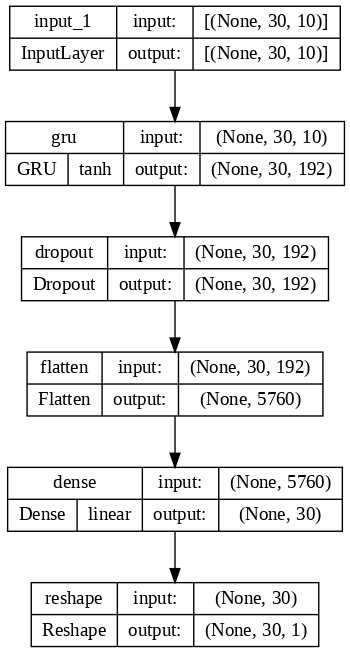

In [ ]:
plot_model(best_model, show_shapes=True, show_layer_names = True,  show_layer_activations=True, dpi=100)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

hist4 =  best_model.fit(single_step_window.train, batch_size=32, epochs=50, verbose=2, validation_data=single_step_window.val, callbacks=[callback])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

Epoch 1/50
39/39 - 3s - loss: 25.6275 - mean_absolute_error: 4.0245 - root_mean_squared_error: 5.0624 - mean_absolute_percentage_error: 24.6726 - mean_squared_error: 25.6275 - val_loss: 23.5171 - val_mean_absolute_error: 3.9291 - val_root_mean_squared_error: 4.8494 - val_mean_absolute_percentage_error: 21.8601 - val_mean_squared_error: 23.5171 - 3s/epoch - 78ms/step
Epoch 2/50
39/39 - 0s - loss: 25.5483 - mean_absolute_error: 4.0216 - root_mean_squared_error: 5.0545 - mean_absolute_percentage_error: 24.6447 - mean_squared_error: 25.5483 - val_loss: 23.5289 - val_mean_absolute_error: 3.9345 - val_root_mean_squared_error: 4.8507 - val_mean_absolute_percentage_error: 21.8971 - val_mean_squared_error: 23.5289 - 341ms/epoch - 9ms/step
Epoch 3/50
39/39 - 0s - loss: 25.1681 - mean_absolute_error: 4.0028 - root_mean_squared_error: 5.0168 - mean_absolute_percentage_error: 24.4848 - mean_squared_error: 25.1681 - val_loss: 23.4142 - val_mean_absolute_error: 3.9320 - val_root_mean_squared_error: 4

In [ ]:
best_model.evaluate(single_step_window.val, return_dict=True)

10/10 [==============================] - 0s 6ms/step - loss: 22.9850 - mean_absolute_error: 3.9017 - root_mean_squared_error: 4.7943 - mean_absolute_percentage_error: 21.3381 - mean_squared_error: 22.9850


{'loss': 22.984962463378906,
 'mean_absolute_error': 3.9017395973205566,
 'root_mean_squared_error': 4.7942633628845215,
 'mean_absolute_percentage_error': 21.338064193725586,
 'mean_squared_error': 22.984960556030273}

In [ ]:
score

{'loss': 23.459278106689453,
 'mean_absolute_error': 3.9920713901519775,
 'root_mean_squared_error': 4.843477725982666,
 'mean_absolute_percentage_error': 20.261445999145508,
 'mean_squared_error': 23.459278106689453}

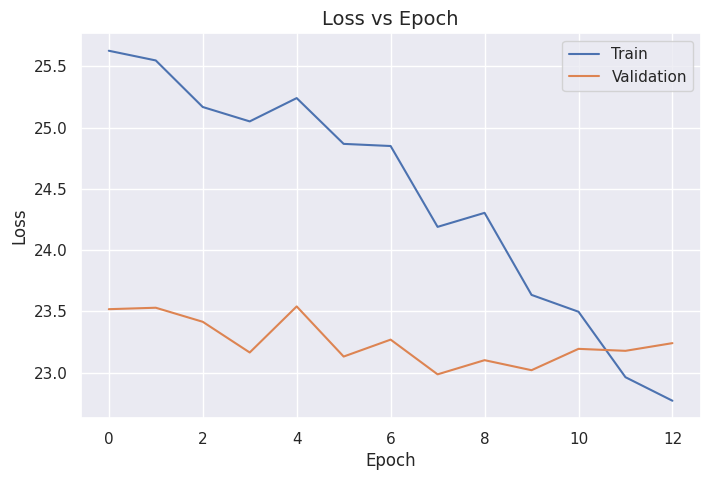

In [ ]:
# "Loss"
plt.figure(figsize=[8,5])
plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])
plt.title('Loss vs Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("stacked_lstm_loss.png", dpi=300)
plt.show()

In [ ]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

# Initialize lists to store t-statistics and p-values
t_statistics = []
p_values = []

from scipy import stats
t_statistic, p_value = stats.ttest_ind(y_pred, y_test)

# Append the results to the lists
t_statistics.append(t_statistic)
p_values.append(p_value)

# Aggregate the results (e.g., by taking the mean)
mean_t_statistic = np.mean(t_statistics)
mean_p_value = np.mean(p_values)

print("Mean t-statistic:", mean_t_statistic)
print("Mean p-value:", mean_p_value)

Mean t-statistic: -1.1423297
Mean p-value: 0.28975928


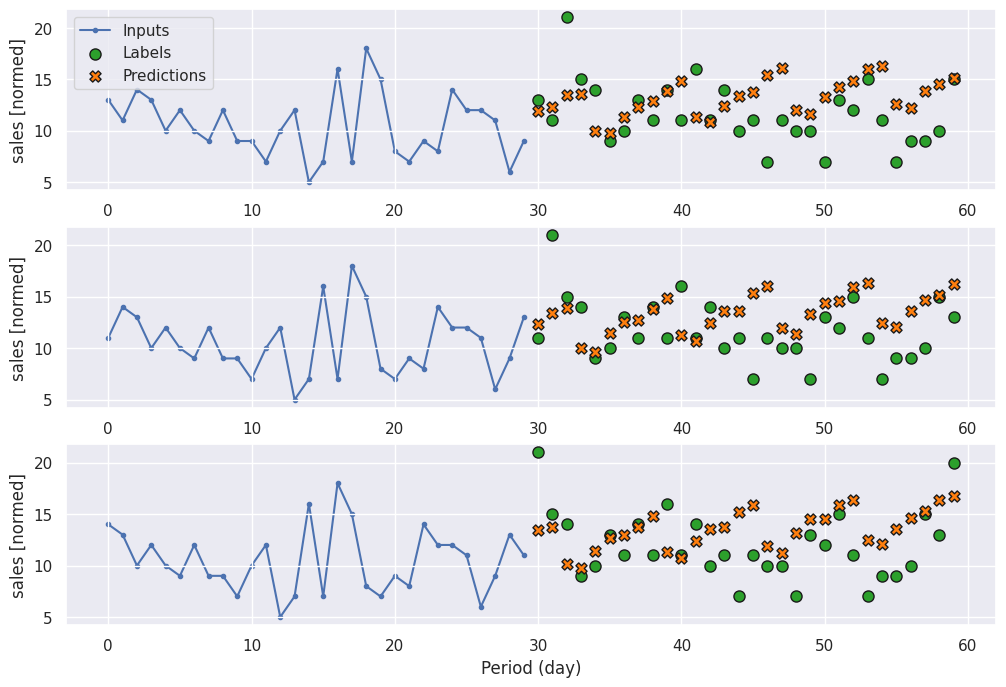

In [ ]:
single_step_window.plot(best_model)

## CNN-LSTM-GRU (Proposed)

In [ ]:
!pip install keras-multi-head

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Bidirectional, Flatten, Layer, Conv1D, Input, Concatenate, GRU, MultiHeadAttention
import keras

def hybrid_model(hp):
    inputs = Input(shape=(OUT_STEPS, 10))

    num_filters = hp.Int('filters_cnn_layer', min_value=16, max_value=512, step=16)
    k_size = hp.Int('kernel_size', min_value=1, max_value=5, step=1)

    model1=Conv1D(num_filters, k_size, activation='relu')(inputs)
    model1=Conv1D(32, 5, activation='relu')(model1)
    #model1=tf.keras.layers.BatchNormalization()(model1)
    #if hp.Choice('pooling_', ['avg', 'max']) == 'max':
    #    model1=MaxPooling1D(pool_size=3)(model1)
    #else:
    #    model1=AveragePooling1D(pool_size=3)(model1)
    model1=MaxPooling1D(pool_size=3)(model1)
    model1=Dense(128, activation='relu')(model1)
    model1=Flatten()(model1)

    model2=Bidirectional(LSTM(units=192, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))(inputs)
    model4 = Dropout(0.2)(model2)
    model2=Flatten()(model2)

    model3=Bidirectional(GRU(units=160, return_sequences=True, go_backwards=True))(inputs)
    model4 = Dropout(0.4)(model4)
    model3=Flatten()(model3)

    model4=LSTM(units=160, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(inputs)
    model4 = Dropout(0.2)(model4)
    model4=LSTM(units=160, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(model4)
    model4 = Dropout(0.2)(model4)
    model4=Flatten()(model4)

    # Concatenate outputs of all models
    concatenated = Concatenate()([model1, model2, model3, model4])

    # Attention Mix
    #CrossAT1 = tf.keras.layers.MultiHeadAttention(num_heads=3, key_dim=1)(model1,model2,model3,model4)

    model = Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros(), activation='linear')(concatenated)
    out = tf.keras.layers.Reshape([OUT_STEPS, num_features])(model)

    model = tf.keras.models.Model(inputs=[inputs], outputs=out)

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])

    return model

tuner = kt.tuners.Hyperband(
    hybrid_model,
    objective='val_mean_squared_error',
    max_epochs=10,
    hyperband_iterations=3, #5
    directory='hybrid_model',
    project_name='demand forecasting')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(single_step_window.train, epochs=10, validation_data=(single_step_window.val), callbacks=[stop_early])
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(30, 10))
best_model.summary()

Trial 67 Complete [00h 00m 26s]
val_mean_squared_error: 26.862653732299805

Best val_mean_squared_error So Far: 23.419565200805664
Total elapsed time: 00h 27m 49s

Search: Running Trial #68

Value             |Best Value So Far |Hyperparameter
144               |96                |filters_cnn_layer
2                 |5                 |kernel_size
2                 |10                |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |0                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


In [ ]:
tuner.results_summary()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)
class ReduceLRBacktrack(tf.keras.callbacks.ReduceLROnPlateau):
    def __init__(self, best_path, *args, **kwargs):
        super(ReduceLRBacktrack, self).__init__(*args, **kwargs)
        self.best_path = best_path

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            logging.warning('Reduce LR on plateau conditioned on metric `%s` '
                            'which is not available. Available metrics are: %s',
                             self.monitor, ','.join(list(logs.keys())))
        if not self.monitor_op(current, self.best): # not new best
            if not self.in_cooldown(): # and we're not in cooldown
                if self.wait+1 >= self.patience: # going to reduce lr
                    # load best model so far
                    # print("\n Backtracking to best model before reducting LR")
                    self.model.load_weights(self.best_path)

        super().on_epoch_end(epoch, logs) # actually reduce LR

model_path = 'model.h5'

lr_reducer = ReduceLRBacktrack(
    best_path = model_path,
    monitor="val_loss",
    factor=0.1,
    patience=5,
    min_lr=1e-10,
    mode='min'
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path, save_best_only=True, monitor='val_loss', mode='min')
hist4 =  best_model.fit(single_step_window.train,
                        batch_size=32,
                        epochs=50,
                        verbose=2,
                        validation_data=single_step_window.val,
                        callbacks=[callback,lr_reducer,checkpoint])
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

In [ ]:
# @title
plot_model(best_model, to_file = 'proposed_demand_forecasting_model.png', show_shapes=True, show_layer_names = True, show_layer_activations=True, dpi=100)

In [ ]:
best_model.evaluate(single_step_window.val, return_dict=True)

In [ ]:
score = best_model.evaluate(single_step_window.test, return_dict=True)
y_pred = best_model.predict(single_step_window.test)

{'loss': 23.024051666259766,
 'mean_absolute_error': 3.9377262592315674,
 'root_mean_squared_error': 4.798338413238525,
 'mean_absolute_percentage_error': 19.754358291625977,
 'mean_squared_error': 23.024051666259766}

In [ ]:
score

In [ ]:
# "Loss"
plt.figure(figsize=[8,5])
plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])
plt.title('Loss vs Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("cnn_bilstm_loss.png", dpi=300)
plt.show()

In [ ]:
# Extract the actual values from the test dataset
actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
actual_values = np.array(actual_values)

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_and_plot_feature(y_test, y_pred, feature_index):
    # Extract the specified feature from y_pred
    y_pred_feature = y_pred[:, :, feature_index]

    # Reshape y_pred_feature to match the shape of y_test
    y_pred_feature_reshaped = np.expand_dims(y_pred_feature, axis=-1)

    # Flatten both y_test and y_pred_feature for evaluation
    y_test_flat = y_test.flatten()
    y_pred_flat = y_pred_feature_reshaped.flatten()

    # Calculate Mean Squared Error and Mean Absolute Error
    mse = mean_squared_error(y_test_flat, y_pred_flat)
    mae = mean_absolute_error(y_test_flat, y_pred_flat)

    print(f'Evaluation for Feature {feature_index + 1}:')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')

    # Plotting actual vs predicted values
    plt.figure(figsize=(12, 6))

    # Plotting actual values
    plt.plot(y_test_flat[:300], label='Actual Sales')

    # Plotting predicted values
    plt.plot(y_pred_flat[:324], label=f'Predicted Sales')

    plt.title(f'Actual vs Predicted Hourly Sales')
    plt.xlabel('Time (Hour)')
    plt.ylabel(f'Sales')
    plt.legend()
    plt.show()

# Assuming y_test has shape (136, 24, 1) and y_pred has shape (136, 24, 10)

feature_index_to_evaluate = 0  # Adjust the feature index you want to evaluate
evaluate_and_plot_feature(actual_values, y_pred, feature_index_to_evaluate)


In [ ]:
# Extract the specified feature from y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_values = []
for _, labels in single_step_window.test:
    actual_values.extend(labels.numpy())
y_test = np.array(actual_values)

# Initialize lists to store t-statistics and p-values
t_statistics = []
p_values = []

from scipy import stats
t_statistic, p_value = stats.ttest_ind(y_pred, y_test)

# Append the results to the lists
t_statistics.append(t_statistic)
p_values.append(p_value)

# Aggregate the results (e.g., by taking the mean)
mean_t_statistic = np.mean(t_statistics)
mean_p_value = np.mean(p_values)

print("Mean t-statistic:", mean_t_statistic)
print("Mean p-value:", mean_p_value)

In [ ]:
single_step_window.plot(best_model)